In [91]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
n = 500
x1 = np.random.normal(100, 15, n)
x2 = np.random.normal(30, 15, n)
x3 = np.random.normal(100, 15, n)
X = np.concatenate([x1, x2,x3])
y1 = np.random.normal(-20, 15, n)
y2 = np.random.normal(10, 20, n)
y3 = np.random.normal(40, 20, n)
Y = np.concatenate([y1, y2,y3])


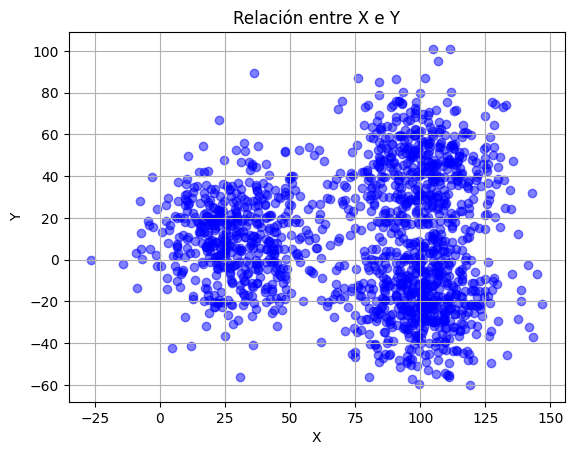

In [93]:
plt.scatter(X, Y, color='blue', alpha=0.5)
plt.title('Relación entre X e Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [94]:
data = np.column_stack((X, Y))

In [95]:
# Paso 1: Inicializar Spark
spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

In [96]:
# Convertir el array de NumPy a un DataFrame
df = spark.createDataFrame(data.tolist(), ["feature1", "feature2"])

# Utilizar VectorAssembler para combinar las características en una sola columna de vectores
assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
dataset = assembler.transform(df)


In [97]:
evaluator = ClusteringEvaluator()

maxSilhouette = float('-inf')  # Iniciar con el valor más bajo posible
optimalK = 2
optimalModel = None 

results = []

# Iterar sobre un rango de valores de k
for k in range(2, 10):  # Ajusta el rango de búsqueda según sea necesario
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    
    # Evaluar el modelo con el evaluador de clustering
    silhouette = evaluator.evaluate(predictions)
       
    # Almacenar los resultados
    results.append((k, silhouette))
    
    # Verificar si este score es el mejor hasta ahora
    if silhouette > maxSilhouette:
        maxSilhouette = silhouette
        optimalK = k
        optimalModel = model 

# Imprimir el mejor score de Silhouette y el k correspondiente
print(f"El mejor Silhouette Score es {maxSilhouette} con k={optimalK}")

# Convertir los resultados en un DataFrame de Pandas
results_df = pd.DataFrame(results, columns=['K', 'Silhouette Score'])

# Mostrar el DataFrame
print(results_df)


El mejor Silhouette Score es 0.7476981295331061 con k=3
   K  Silhouette Score
0  2          0.649068
1  3          0.747698
2  4          0.646143
3  5          0.539474
4  6          0.471015
5  7          0.543400
6  8          0.474452
7  9          0.492301


In [98]:
# Mostrar los centros de los clusters
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)



Cluster Centers: 
[87.56665215 30.05732367]
[ 88.96898028 -29.77241417]
[15.51745743 14.65760021]
[35.47494901 -8.76000969]
[98.45708784 62.15743378]
[114.44029171 -26.66803407]
[41.53446113 29.43271552]
[113.93257678  35.96428287]
[99.0945934  -3.20931855]


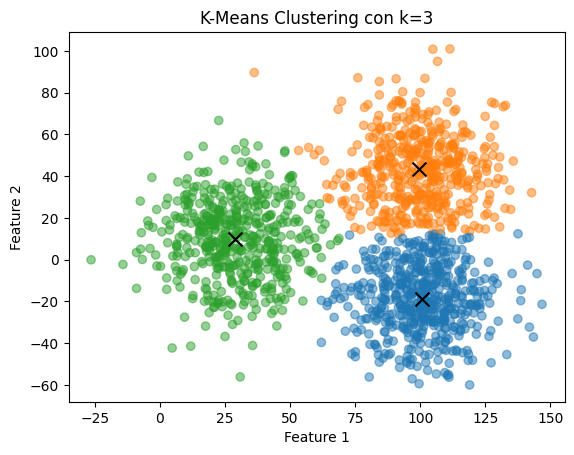

In [99]:
optimalPredictions = optimalModel.transform(dataset)

pandas_df = optimalPredictions.select("feature1", "feature2", "prediction").toPandas()

# Graficar los resultados
fig, ax = plt.subplots()

colors = colors = {i: plt.cm.tab10(i / 10) for i in range(optimalK)}  # Ajusta según el número de clusters

ax.scatter(pandas_df['feature1'], pandas_df['feature2'], c=pandas_df['prediction'].map(colors), alpha=0.5)

# Graficar los centros de los clusters
centers = optimalModel.clusterCenters()
for center in centers:
    ax.scatter(center[0], center[1], s=100, c='black', marker='x')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'K-Means Clustering con k={optimalK}')
plt.show()

In [100]:
# No olvides detener la sesión Spark cuando hayas terminado
spark.stop()